## Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
from collections import defaultdict
import itertools
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('wordnet')  # downloads WordNet data
nltk.download('omw-1.4')  # downloads additional wordnet data for lemmatization
nltk.download('stopwords')  # downloads stopwords (if not already downloaded)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
)
from wordcloud import WordCloud
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

from emotion_dataset import EmotionDataset
from loader import loader
from train_model import train_model
from plot_scores import plot_scores
from predict import predict
from predict_on_fly import predict_on_fly
from metrics import compute_metrics, print_metrics, save_metrics
import transformer_model

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\difj6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\difj6\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\difj6\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\difj6\OneDrive - Syddansk Universitet\Documents\Uni\7. semester\DM873 Deep learning\Project2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


## Load and save dataset

In [4]:
train_csv_path = "data/train.csv"
val_csv_path = "data/val.csv"
test_csv_path = "data/test.csv"

train_df, val_df, test_df = loader(train_csv_path, val_csv_path, test_csv_path)

# Task 1: Data Preparation

## Data set

In [6]:
print(f"# train sentences: {len(train_df)}")
print(f"# validation sentences: {len(val_df)}")
print(f"# test sentences: {len(test_df)}")

print(train_df)

# train sentences: 16000
# validation sentences: 2000
# test sentences: 2000
                                                    text  label label_name
0                                i didnt feel humiliated      0    sadness
1      i can go from feeling so hopeless to so damned...      0    sadness
2       im grabbing a minute to post i feel greedy wrong      3      anger
3      i am ever feeling nostalgic about the fireplac...      2       love
4                                   i am feeling grouchy      3      anger
...                                                  ...    ...        ...
15995  i just had a very brief time in the beanbag an...      0    sadness
15996  i am now turning and i feel pathetic that i am...      0    sadness
15997                     i feel strong and good overall      1        joy
15998  i feel like this was such a rude comment and i...      3      anger
15999  i know a lot but i feel so stupid because i ca...      0    sadness

[16000 rows x 3 column

## Step 1: Dataset Preparation

### Label distribution

Number of classes: 6
Training Label Mapping and Distribution:
 label label_name  count  percentage
     0    sadness   4666       29.16
     1        joy   5362       33.51
     2       love   1304        8.15
     3      anger   2159       13.49
     4       fear   1937       12.11
     5   surprise    572        3.58


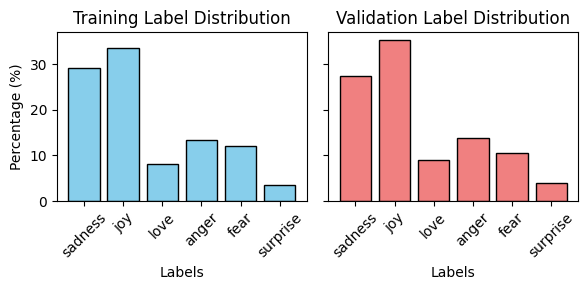

In [7]:
# Calculate label distributions and percentages for training and validation sets
def calculate_distribution(df):
    label_distribution = df["label_name"].value_counts().reset_index()
    label_distribution.columns = ["label_name", "count"]
    label_distribution["percentage"] = round((label_distribution["count"] / label_distribution["count"].sum()) * 100, 2)
    return label_distribution

# Calculate distributions
train_distribution = calculate_distribution(train_df)
val_distribution = calculate_distribution(val_df)

# Merge with label mapping for alignment
label_map_df = train_df[["label", "label_name"]].drop_duplicates().sort_values("label")
label_map = dict(zip(label_map_df["label"], label_map_df["label_name"]))
train_labels_df = label_map_df.merge(train_distribution, on="label_name", how="left")
val_labels_df = label_map_df.merge(val_distribution, on="label_name", how="left")

# Print training label mapping and distribution
num_classes = len(label_map_df)
print(f"Number of classes: {num_classes}")
print("Training Label Mapping and Distribution:")
print(train_labels_df.to_string(index=False))

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

# Training set
axes[0].bar(train_labels_df["label_name"], train_labels_df["percentage"], color="skyblue", edgecolor="black")
axes[0].set_title("Training Label Distribution")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Percentage (%)")
axes[0].tick_params(axis='x', rotation=45)

# Validation set
axes[1].bar(val_labels_df["label_name"], val_labels_df["percentage"], color="lightcoral", edgecolor="black")
axes[1].set_title("Validation Label Distribution")
axes[1].set_xlabel("Labels")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Step 2: Tokenizing

### Tokenizer

In [8]:
tokenizer = RegexpTokenizer(r"[a-zA-Z]+|[!?'´`]+") # sequence that don’t match the pattern act as separators.
example_sentence = "This?.is,a:cu123stom;tokenization example!<"
example_tokens = tokenizer.tokenize(example_sentence)
print(example_tokens)

['This', '?', 'is', 'a', 'cu', 'stom', 'tokenization', 'example', '!']


### Tokenize each split

In [9]:
train_df["tokens"] = train_df["text"].str.lower().apply(tokenizer.tokenize)
val_df["tokens"] = val_df["text"].str.lower().apply(tokenizer.tokenize)
test_df["tokens"] = test_df["text"].str.lower().apply(tokenizer.tokenize)

train_vocab = set(token for tokens in train_df["tokens"] for token in tokens)

print(f"# words in train vocab: {len(train_vocab)}")

# words in train vocab: 15212


### Word frequency

In [10]:
def get_top_words_per_class(tokens_in, top_n=10):
    tokens_by_class = defaultdict(list)
    for tokens, label in zip(tokens_in, train_df["label_name"]):
        tokens_by_class[label].append(tokens)
    tokens_by_class = dict(tokens_by_class)
    results = []
    for label_name, tokens in tokens_by_class.items():
        flat_tokens = list(itertools.chain.from_iterable(tokens))
        most_common = Counter(flat_tokens).most_common(top_n)
        for word, count in most_common:
            results.append({"Label_name": label_name, "Word": word, "Count": count})
    return pd.DataFrame(results)

print(get_top_words_per_class(train_df["tokens"], top_n=10).to_string(index=False))

Label_name    Word  Count
   sadness       i   7635
   sadness    feel   3299
   sadness     and   2692
   sadness      to   2335
   sadness     the   2155
   sadness       a   1656
   sadness feeling   1523
   sadness      of   1422
   sadness    that   1299
   sadness      my   1245
     anger       i   3576
     anger    feel   1459
     anger     and   1258
     anger      to   1162
     anger     the   1109
     anger       a    791
     anger feeling    721
     anger    that    705
     anger      of    630
     anger      my    573
      love       i   2120
      love    feel    929
      love     and    902
      love      to    860
      love     the    780
      love       a    571
      love      of    482
      love    that    460
      love      my    399
      love feeling    378
  surprise       i    927
  surprise    feel    356
  surprise     and    354
  surprise     the    335
  surprise      to    267
  surprise       a    256
  surprise    that    212
  surprise f

### Data cleaning (remove stopwords and stem)

In [11]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

def preprocess_tokens(tokens):
    return [stemmer.stem(word) for word in tokens if word not in stop_words]

train_df["processed_tokens"] = train_df["tokens"].apply(preprocess_tokens)
val_df["processed_tokens"] = val_df["tokens"].apply(preprocess_tokens)
test_df["processed_tokens"] = test_df["tokens"].apply(preprocess_tokens)

print(get_top_words_per_class(train_df["processed_tokens"], top_n=10).to_string(index=False))

Label_name      Word  Count
   sadness      feel   4994
   sadness      like    881
   sadness        im    683
   sadness      know    297
   sadness       get    284
   sadness    realli    276
   sadness      time    271
   sadness      make    245
   sadness      want    244
   sadness        go    235
     anger      feel   2261
     anger      like    391
     anger        im    342
     anger       get    175
     anger      time    140
     anger      want    133
     anger     irrit    128
     anger    realli    124
     anger      know    122
     anger      hate    113
      love      feel   1406
      love      like    366
      love      love    277
      love        im    193
      love   support    103
      love    realli     92
      love      know     89
      love      want     89
      love      time     82
      love      care     82
  surprise      feel    601
  surprise      amaz    107
  surprise      like     92
  surprise        im     91
  surprise   impress

### Frequency of words

In [12]:
word_freq = Counter(itertools.chain.from_iterable(train_df["processed_tokens"]))
pd.DataFrame(word_freq.items(), columns=["Word", "Count"]).sort_values(by="Count", ascending=False).to_csv("results/word_frequencies.csv", index=False)
print(pd.DataFrame(word_freq.most_common(100), columns=["Word", "Count"]).to_string(index=False))

   Word  Count
   feel  16961
   like   3017
     im   2430
    get    981
   time    979
 realli    942
   know    938
   make    935
     go    882
   want    867
   love    805
  littl    736
  think    736
    day    675
  thing    672
  peopl    664
    one    647
  would    646
   even    600
  still    598
    ive    587
   life    555
    way    528
   need    521
    bit    521
 someth    514
   much    496
   dont    482
   work    471
  could    453
    say    450
  start    445
   look    423
    see    419
   back    414
    tri    410
   good    408
 pretti    392
  right    357
  alway    356
   come    351
   help    342
 friend    340
   also    337
   year    336
  today    332
    use    326
   take    317
 around    315
 person    303
   cant    301
   made    296
   hate    285
   well    279
 though    274
  happi    274
  didnt    272
    got    271
  write    270
   live    268
   felt    266
    lot    264
  never    264
thought    263
   hope    261
 someon   

### Remove additional words

In [13]:
additional_words_to_remove = ["feel", "realli", "im", "know", "also", "http"]

def remove_additional_words(tokens):
    return [word for word in tokens if word not in additional_words_to_remove]

train_df["processed_tokens"] = train_df["processed_tokens"].apply(remove_additional_words)
val_df["processed_tokens"] = val_df["processed_tokens"].apply(remove_additional_words)
test_df["processed_tokens"] = test_df["processed_tokens"].apply(remove_additional_words)

train_df["processed_text"] = train_df["processed_tokens"].apply(" ".join)
val_df["processed_text"] = val_df["processed_tokens"].apply(" ".join)
test_df["processed_text"] = test_df["processed_tokens"].apply(" ".join)

print(get_top_words_per_class(train_df["processed_tokens"], top_n=10).to_string(index=False))

Label_name      Word  Count
   sadness      like    881
   sadness       get    284
   sadness      time    271
   sadness      make    245
   sadness      want    244
   sadness        go    235
   sadness       day    224
   sadness     thing    221
   sadness       ive    217
   sadness     think    212
     anger      like    391
     anger       get    175
     anger      time    140
     anger      want    133
     anger     irrit    128
     anger      hate    113
     anger     thing    109
     anger      make    108
     anger        go    108
     anger     think    105
      love      like    366
      love      love    277
      love   support    103
      love      want     89
      love      time     82
      love      care     82
      love      long     72
      love       one     70
      love       get     70
      love     sweet     69
  surprise      amaz    107
  surprise      like     92
  surprise   impress     63
  surprise overwhelm     58
  surprise     weird

### WordCloud

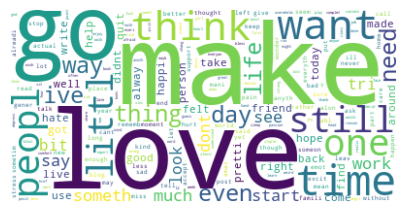

In [14]:
wordcloud = WordCloud(width=400, height=200, background_color="white").generate(" ".join(list(itertools.chain.from_iterable(train_df["processed_tokens"]))))
plt.figure(figsize=(5, 3))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Sentence length distribution

Length range for train: from 1 to 34 words
Mean length for train: 8 words
Standard deviation for train: 5


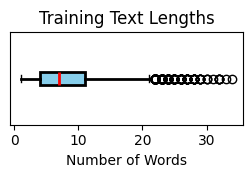

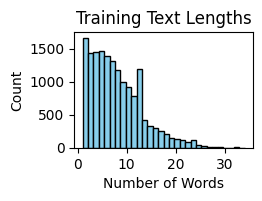

In [15]:
train_lengths = [len(tokens) for tokens in train_df["processed_tokens"]]
mean_length = np.mean(train_lengths)
std_dev = np.std(train_lengths)

print(f"Length range for train: from {min(train_lengths)} to {max(train_lengths)} words")
print(f"Mean length for train: {mean_length:.0f} words")
print(f"Standard deviation for train: {std_dev:.0f}")

# Plot boxplot
plt.figure(figsize=(3, 1.2))
plt.boxplot(
    train_lengths,
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="skyblue", linewidth=2), # larger, colored box
    whiskerprops=dict(linewidth=2),  # Thicker whiskers
    medianprops=dict(color="red", linewidth=2), # highlight the median
)
plt.title("Training Text Lengths")
plt.xlabel("Number of Words")
plt.yticks([])
plt.show()

# Plot distribution of lengths
plt.figure(figsize=(2.3, 1.5))
plt.hist(train_lengths, bins=30, color="skyblue", edgecolor="black")
plt.title("Training Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

### Set max and min length

In [16]:
# Set max length for the model. If sentence is longer, truncate it. If shorter, pad it.
# Set min length to remove very short sentences from the training set.
max_length = 10
min_length = 3

print(f"# train sentences before filtering: {len(train_df)}")
train_df = train_df[train_df["processed_tokens"].apply(len) >= min_length]
print(f"# train sentences after filtering: {len(train_df)}")

# train sentences before filtering: 16000
# train sentences after filtering: 14331


## Step 3: Build a vocabulary

In [17]:
vocab = {"<PAD>": 0, "<UNK>": 1}
for tokens in train_df["processed_tokens"]:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab)

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

reverse_vocab = {v: k for k, v in vocab.items()}

Vocabulary size: 10336


## Step 4: Encode all texts with the vocabulary

In [18]:
def encode(tokens): # i.e. words to integers
    return [vocab[token] if token in vocab else 1 for token in tokens]

train_df["encoded"] = train_df["processed_tokens"].apply(encode)
val_df["encoded"] = val_df["processed_tokens"].apply(encode)
test_df["encoded"] = test_df["processed_tokens"].apply(encode)

## Step 5: Maximum sequence length

In [19]:
def pad(sequence):
    return sequence[:max_length] + [0] * (max_length - len(sequence))

train_df["padded"] = train_df["encoded"].apply(pad)
val_df["padded"] = val_df["encoded"].apply(pad)
test_df["padded"] = test_df["encoded"].apply(pad)

# Task 2: RNN model

## Model class

In [21]:
class RNN_model(nn.Module):
    def __init__(self, type, vocab_size, embedding_dim, hidden_size, num_classes, padding_idx=0, num_layers=1, dropout_rnn=0, dropout_fc=0):
        super(RNN_model, self).__init__()
        # embedding_dim: size of each embedding vector
        # hidden_size: number of features in the hidden state
        # num_layers: number of recurrent layers
        # bias: introduces a bias
        # batch_first: input and output tensors are provided as (batch, seq, feature)
        # dropout: if non-zero, introduces a dropout layer on the outputs of each RNN layer except the last layer

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=padding_idx)
        if type == "RNN":
            self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, bias=True, batch_first=True, dropout=dropout_rnn, nonlinearity="tanh")
        elif type == "GRU":
            self.rnn = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, bias=True, batch_first=True, dropout=dropout_rnn)
        elif type == "LSTM":
            self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, bias=True, batch_first=True, dropout=dropout_rnn)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout_fc)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # extract last hidden state for each sequence
        x = self.dropout(x) # apply dropout to the last hidden state
        x = self.fc(x) # pass last hidden state through the fully connected layer
        return x


## Hyper parameter tuning

In [19]:
train_dataset = EmotionDataset(train_df["padded"].tolist(), train_df["label"].tolist())
val_dataset = EmotionDataset(val_df["padded"].tolist(), val_df["label"].tolist())
test_dataset = EmotionDataset(test_df["padded"].tolist(), test_df["label"].tolist())

In [ ]:
def grid_search(vocab_size, num_classes, train_dataset, val_dataset, label_map, device):
    param_grid = {
        # The best hyperparameters found is commented out
        "type": ["LSTM", "GRU", "RNN"], # "LSTM"
        "embedding_dim": [100, 75], # 75
        "hidden_size": [512, 256], # 256
        "layers": [1, 2], # 1
        "dropout_rnn": [0.0, 0.2], # 0.0
        "dropout_fc": [0.4, 0.6], # 0.4
        "learning_rate": [0.001, 0.0005], # 0.0001
        "reg_lambda": [0.0001, 0.00005], # 0.0001
        "batch_size": [16, 32], # 16
    }
    
    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    configs = [dict(zip(keys, v)) for v in itertools.product(*values)]
    total_configs = len(configs)

    best_val_f1_score = 0
    results_list = []
    for i, config in enumerate(configs):
        label = f"model_{i}"
        print(f"Training model: {label} ({i+1}/{total_configs})")
        print(json.dumps(config, indent=4))
        
        train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
        
        # Model
        model = RNN_model(
            type=config["type"],
            vocab_size=vocab_size,
            embedding_dim=config["embedding_dim"],
            hidden_size=config["hidden_size"],
            num_classes=num_classes,
            num_layers=config["layers"],
            dropout_rnn=config["dropout_rnn"],
            dropout_fc=config["dropout_fc"],
        )

        # Train
        results = train_model(
            label=label,
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            label_map=label_map,
            device=device,
            optimizer_type="AdamW",
            learning_rate=config["learning_rate"],
            reg_type="L2",
            reg_lambda=config["reg_lambda"],
            num_epochs=10
        )
        
        # Track the best model
        current_val_f1_score = max(results["val_f1_scores"])
        if current_val_f1_score > best_val_f1_score:
            best_val_f1_score = current_val_f1_score
            best_model_label = label
            print(f"New best model found: {best_model_label} with val f1 score: {best_val_f1_score:.4f}")

        # Add results to list
        results["config"] = config
        results_list.append(results)

    # Save results
    with open("results/grid_search_results.json", "w") as f:
        json.dump(results_list, f, indent=4)
    
    print(f"Best model found: {best_model_label}")

grid_search(vocab_size, num_classes, train_dataset, val_dataset, label_map, device)

## Best RNN model

Epoch 1/4 (13s) | Train: loss 43.7012, acc 34.97%, f1 28.47% | Val: loss 1.3089, acc 45.45%, f1 39.97%
Epoch 2/4 (14s) | Train: loss 12.8225, acc 64.15%, f1 63.64% | Val: loss 0.7115, acc 76.85%, f1 76.32%
Epoch 3/4 (15s) | Train: loss 4.8592, acc 82.06%, f1 81.95% | Val: loss 0.5541, acc 81.95%, f1 81.86%
Epoch 4/4 (16s) | Train: loss 2.4755, acc 86.03%, f1 86.00% | Val: loss 0.528, acc 81.90%, f1 81.53%
Total Training Time: 58s

accuracy: 0.819
f1: 0.8153
precision: 0.8181
recall: 0.819
classification report:
              precision    recall  f1-score   support

     sadness       0.86      0.86      0.86       550
         joy       0.82      0.89      0.85       704
        love       0.79      0.51      0.62       178
       anger       0.80      0.84      0.82       275
        fear       0.77      0.76      0.77       212
    surprise       0.73      0.75      0.74        81

    accuracy                           0.82      2000
   macro avg       0.80      0.77      0.78      

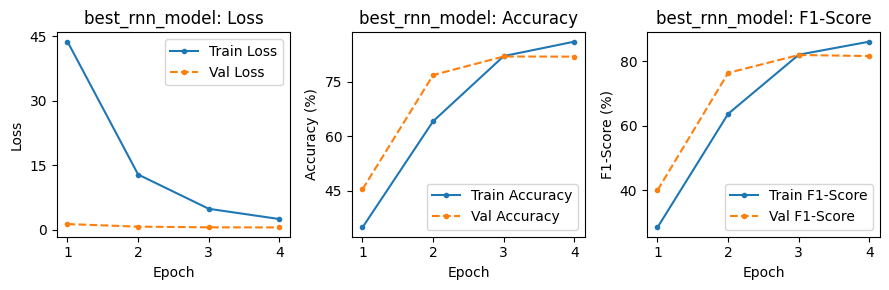

In [21]:
label = "best_rnn_model"
best_batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

best_rnn_model = RNN_model(
    type="LSTM",
    vocab_size=vocab_size,
    embedding_dim=75,
    hidden_size=256,
    num_classes=num_classes,
    num_layers=1,
    dropout_rnn=0.0,
    dropout_fc=0.4,
)

best_rnn_results = train_model(
    label=label,
    model=best_rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    label_map=label_map,
    device=device,
    optimizer_type="AdamW",
    learning_rate=0.001,
    reg_type="L2",
    reg_lambda=0.0001,
    num_epochs=4
)

plot_scores(best_rnn_results, label)

# Task 3: Transformer model

In [21]:
batch_size = 32
train_dataset = EmotionDataset(train_df["padded"].tolist(), train_df["label"].tolist())
val_dataset = EmotionDataset(val_df["padded"].tolist(), val_df["label"].tolist())
test_dataset = EmotionDataset(test_df["padded"].tolist(), test_df["label"].tolist())
train_labels = train_df["label"].tolist()
val_labels = val_df["label"].tolist()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
n_embeds = 10336
num_epochs = 50


In [ ]:
config = {
        "label": "transformer1",
        "d_key": 64,
        "n_heads": 8,
        "mlp_factor": 4,
        "d_model": 128,
        "n_layers": 12,
        "dropout1": 0.5,
        "dropout2": 0.25,
        "optimizer_type": "Adam",
        "learning_rate": 0.0003,
        "weight_decay": 0,
        "reg_type": "L1",
        "reg_lambda": 1e-4,
    }
print(f"Training model: {config['label']}")
model = transformer_model.TransformerClassifier(n_embeds=n_embeds, n_classes=6, d_model=config["d_model"], d_key=config["d_key"], n_heads=config["n_heads"], mlp_factor=config["mlp_factor"], n_layers=config["n_layers"], device = device, dropout1=config["dropout1"], dropout2=config["dropout2"])
results = train_model(
    label=config["label"],
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    label_map=label_map,
    device=device,
    optimizer_type=config["optimizer_type"],
    learning_rate=config["learning_rate"],
    weight_decay=config["weight_decay"],
    reg_type=config["reg_type"],
    reg_lambda=config["reg_lambda"],
    num_epochs=num_epochs,
)
plot_scores(results, config["label"])

Training model: transformer1
Epoch 1/50 (149s) | Train: loss 104.6127, acc 33.84%, f1 23.44% | Val: loss 1.5657, acc 36.30%, f1 26.13%
Epoch 2/50 (138s) | Train: loss 83.0827, acc 36.87%, f1 27.41% | Val: loss 1.5251, acc 39.85%, f1 28.12%
Epoch 3/50 (138s) | Train: loss 69.1212, acc 41.07%, f1 33.18% | Val: loss 1.4552, acc 44.70%, f1 37.03%
Epoch 4/50 (143s) | Train: loss 57.2679, acc 45.41%, f1 39.91% | Val: loss 1.3714, acc 48.40%, f1 42.21%
Epoch 5/50 (135s) | Train: loss 47.2436, acc 51.04%, f1 47.29% | Val: loss 1.2863, acc 51.25%, f1 48.06%
Epoch 6/50 (134s) | Train: loss 39.01, acc 57.25%, f1 55.08% | Val: loss 1.3131, acc 46.65%, f1 44.18%
Epoch 7/50 (133s) | Train: loss 32.2532, acc 63.80%, f1 62.42% | Val: loss 0.9758, acc 65.75%, f1 64.66%
Epoch 8/50 (134s) | Train: loss 26.7862, acc 69.05%, f1 68.14% | Val: loss 0.9382, acc 66.80%, f1 66.71%
Epoch 9/50 (135s) | Train: loss 22.4123, acc 72.73%, f1 72.06% | Val: loss 0.8174, acc 70.75%, f1 69.76%
Epoch 10/50 (134s) | Train:

KeyboardInterrupt: 

Train multiple:

Training model: transformer1
Epoch 1/50 (144s) | Train: loss 96.9733, acc 33.00%, f1 22.14% | Val: loss 1.589, acc 35.20%, f1 18.33%
Epoch 2/50 (135s) | Train: loss 49.1803, acc 33.41%, f1 21.32% | Val: loss 1.5847, acc 35.20%, f1 18.33%
Epoch 3/50 (137s) | Train: loss 25.3396, acc 33.40%, f1 21.09% | Val: loss 1.5806, acc 35.20%, f1 18.33%
Epoch 4/50 (133s) | Train: loss 13.2402, acc 33.93%, f1 22.90% | Val: loss 1.5762, acc 35.20%, f1 18.33%
Epoch 5/50 (133s) | Train: loss 7.0348, acc 43.37%, f1 32.92% | Val: loss 1.1519, acc 57.25%, f1 44.11%
Epoch 6/50 (133s) | Train: loss 3.6965, acc 63.81%, f1 57.44% | Val: loss 0.7387, acc 76.20%, f1 74.65%
Epoch 7/50 (133s) | Train: loss 1.9597, acc 78.95%, f1 77.69% | Val: loss 0.5232, acc 82.75%, f1 82.35%
Epoch 8/50 (133s) | Train: loss 1.1629, acc 84.24%, f1 83.98% | Val: loss 0.5636, acc 81.00%, f1 80.36%
Epoch 9/50 (134s) | Train: loss 0.8026, acc 85.97%, f1 85.86% | Val: loss 0.4916, acc 83.20%, f1 83.27%
Epoch 10/50 (134s) | Train: loss

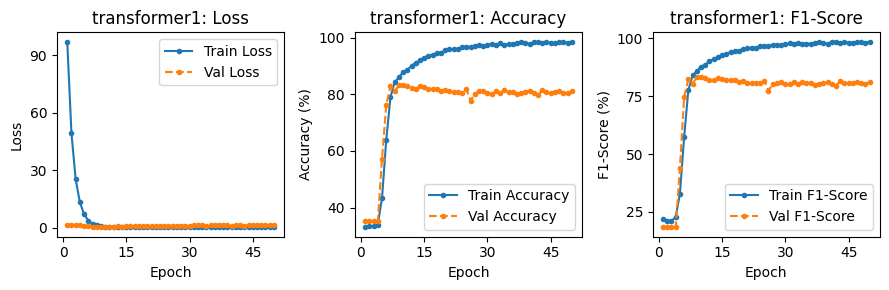

Training model: transformer1
Epoch 1/50 (82s) | Train: loss 97.2039, acc 33.75%, f1 23.46% | Val: loss 1.5919, acc 35.20%, f1 18.33%
Epoch 2/50 (81s) | Train: loss 49.3732, acc 39.08%, f1 29.91% | Val: loss 1.3001, acc 52.10%, f1 42.33%
Epoch 3/50 (82s) | Train: loss 25.4834, acc 59.54%, f1 55.89% | Val: loss 0.8757, acc 70.95%, f1 69.00%
Epoch 4/50 (82s) | Train: loss 13.448, acc 76.16%, f1 75.80% | Val: loss 0.5766, acc 81.05%, f1 81.05%
Epoch 5/50 (81s) | Train: loss 7.3194, acc 83.11%, f1 83.00% | Val: loss 0.5299, acc 83.75%, f1 83.67%
Epoch 6/50 (81s) | Train: loss 4.1823, acc 85.20%, f1 85.11% | Val: loss 0.5028, acc 83.50%, f1 83.19%
Epoch 7/50 (82s) | Train: loss 2.5564, acc 86.44%, f1 86.36% | Val: loss 0.496, acc 82.80%, f1 82.55%
Epoch 8/50 (82s) | Train: loss 1.7045, acc 87.54%, f1 87.50% | Val: loss 0.4964, acc 82.75%, f1 82.64%
Epoch 9/50 (82s) | Train: loss 1.2573, acc 88.50%, f1 88.46% | Val: loss 0.5012, acc 83.20%, f1 83.28%
Epoch 10/50 (82s) | Train: loss 1.009, acc

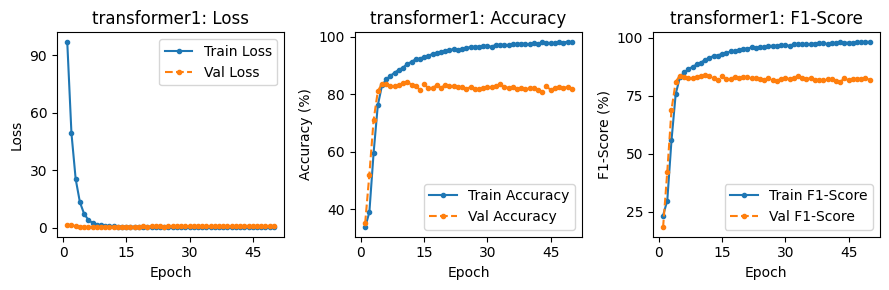

Training model: transformer1
Epoch 1/50 (14739s) | Train: loss 121.004, acc 37.07%, f1 29.60% | Val: loss 1.3999, acc 46.70%, f1 39.39%
Epoch 2/50 (82s) | Train: loss 98.1799, acc 58.94%, f1 57.08% | Val: loss 0.9227, acc 67.00%, f1 65.84%
Epoch 3/50 (81s) | Train: loss 80.4672, acc 74.01%, f1 73.68% | Val: loss 0.7157, acc 75.20%, f1 74.52%
Epoch 4/50 (82s) | Train: loss 66.4574, acc 80.35%, f1 80.19% | Val: loss 0.6151, acc 78.45%, f1 78.25%
Epoch 5/50 (82s) | Train: loss 55.0446, acc 83.90%, f1 83.78% | Val: loss 0.6656, acc 76.60%, f1 76.20%
Epoch 6/50 (84s) | Train: loss 45.6439, acc 85.19%, f1 85.13% | Val: loss 0.6324, acc 78.55%, f1 78.16%
Epoch 7/50 (81s) | Train: loss 37.8457, acc 87.12%, f1 87.07% | Val: loss 0.5792, acc 80.50%, f1 80.06%
Epoch 8/50 (82s) | Train: loss 31.3917, acc 88.51%, f1 88.46% | Val: loss 0.6404, acc 80.05%, f1 80.07%
Epoch 9/50 (81s) | Train: loss 26.0567, acc 90.24%, f1 90.22% | Val: loss 0.6466, acc 79.80%, f1 79.64%
Epoch 10/50 (81s) | Train: loss 

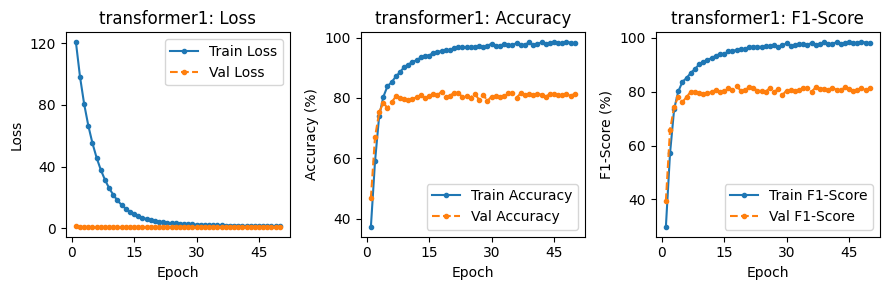

Training model: transformer1
Epoch 1/50 (76s) | Train: loss 82.2925, acc 34.29%, f1 24.75% | Val: loss 1.5574, acc 36.80%, f1 23.02%
Epoch 2/50 (76s) | Train: loss 42.3212, acc 37.95%, f1 30.19% | Val: loss 1.4555, acc 41.45%, f1 35.54%
Epoch 3/50 (76s) | Train: loss 20.4304, acc 51.57%, f1 48.30% | Val: loss 1.0411, acc 60.90%, f1 58.91%
Epoch 4/50 (75s) | Train: loss 9.99, acc 68.06%, f1 67.05% | Val: loss 0.7319, acc 75.05%, f1 74.61%
Epoch 5/50 (76s) | Train: loss 5.4968, acc 77.47%, f1 77.12% | Val: loss 0.7871, acc 72.00%, f1 71.46%
Epoch 6/50 (76s) | Train: loss 3.6127, acc 80.69%, f1 80.47% | Val: loss 0.5873, acc 79.50%, f1 79.08%
Epoch 7/50 (76s) | Train: loss 2.774, acc 82.47%, f1 82.33% | Val: loss 0.5976, acc 79.30%, f1 79.41%
Epoch 8/50 (76s) | Train: loss 2.3222, acc 84.29%, f1 84.21% | Val: loss 0.5352, acc 81.90%, f1 81.58%
Epoch 9/50 (76s) | Train: loss 2.0781, acc 84.43%, f1 84.31% | Val: loss 0.5471, acc 82.00%, f1 81.96%
Epoch 10/50 (76s) | Train: loss 1.8709, acc 

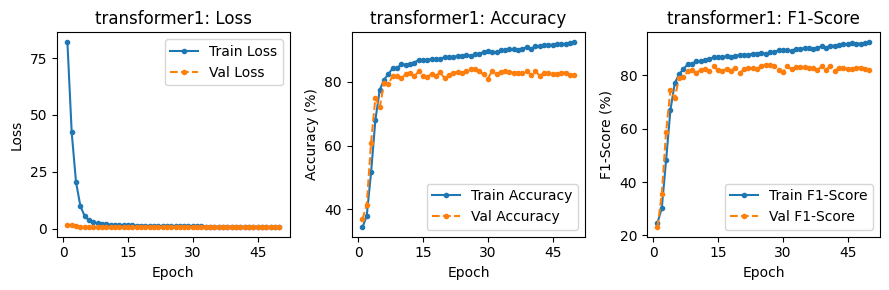

Training model: transformer1
Epoch 1/50 (81s) | Train: loss 96.766, acc 33.05%, f1 22.04% | Val: loss 1.5867, acc 35.25%, f1 18.74%
Epoch 2/50 (81s) | Train: loss 49.0517, acc 33.76%, f1 20.95% | Val: loss 1.5804, acc 35.20%, f1 18.33%
Epoch 3/50 (81s) | Train: loss 25.2465, acc 33.62%, f1 19.99% | Val: loss 1.5867, acc 32.80%, f1 25.38%
Epoch 4/50 (80s) | Train: loss 13.1762, acc 33.57%, f1 20.60% | Val: loss 1.5771, acc 35.20%, f1 18.33%
Epoch 5/50 (81s) | Train: loss 7.1074, acc 33.88%, f1 22.06% | Val: loss 1.5846, acc 31.65%, f1 24.29%
Epoch 6/50 (80s) | Train: loss 4.1231, acc 33.76%, f1 22.37% | Val: loss 1.5732, acc 34.30%, f1 25.59%
Epoch 7/50 (80s) | Train: loss 2.4666, acc 48.87%, f1 40.90% | Val: loss 1.0711, acc 60.05%, f1 51.55%
Epoch 8/50 (81s) | Train: loss 1.5283, acc 64.10%, f1 58.47% | Val: loss 1.087, acc 58.20%, f1 54.25%
Epoch 9/50 (81s) | Train: loss 1.0815, acc 71.67%, f1 67.74% | Val: loss 0.7549, acc 71.95%, f1 70.18%
Epoch 10/50 (81s) | Train: loss 0.7306, ac

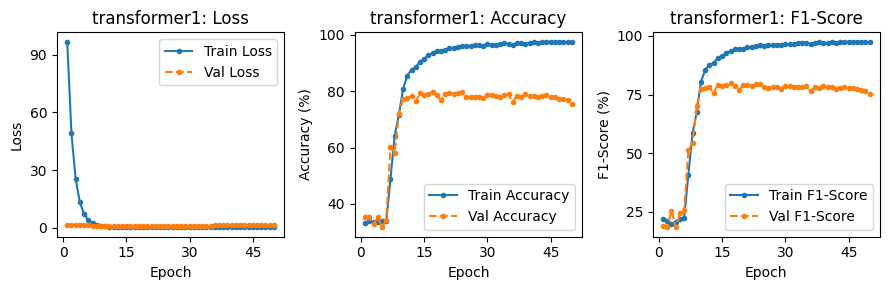

In [25]:
configurations = [
    #heads 16
    {
        "label": "transformer1",
        "d_key": 64,
        "n_heads": 16,
        "mlp_factor": 4,
        "d_model": 128,
        "n_layers": 6,
        "dropout1": 0.5,
        "dropout2": 0.25,
        "optimizer_type": "Adam",
        "learning_rate": 0.001,
        "weight_decay": 0,
        "reg_type": "L2",
        "reg_lambda": 1e-4,
    },
    # mlp_factor 2
    {
        "label": "transformer1",
        "d_key": 64,
        "n_heads": 8,
        "mlp_factor": 2,
        "d_model": 128,
        "n_layers": 6,
        "dropout1": 0.5,
        "dropout2": 0.25,
        "optimizer_type": "Adam",
        "learning_rate": 0.001,
        "weight_decay": 0,
        "reg_type": "L2",
        "reg_lambda": 1e-4,
    },
    # 0,0003 learning rate
    {
        "label": "transformer1",
        "d_key": 64,
        "n_heads": 8,
        "mlp_factor": 4,
        "d_model": 128,
        "n_layers": 6,
        "dropout1": 0.5,
        "dropout2": 0.25,
        "optimizer_type": "Adam",
        "learning_rate": 0.0003,
        "weight_decay": 0,
        "reg_type": "L2",
        "reg_lambda": 1e-4,
    },
    # L1 reg
    {
        "label": "transformer1",
        "d_key": 64,
        "n_heads": 8,
        "mlp_factor": 4,
        "d_model": 128,
        "n_layers": 6,
        "dropout1": 0.5,
        "dropout2": 0.25,
        "optimizer_type": "Adam",
        "learning_rate": 0.001,
        "weight_decay": 0,
        "reg_type": "L1",
        "reg_lambda": 1e-4,
    },
    # More dropout
    {
        "label": "transformer1",
        "d_key": 64,
        "n_heads": 8,
        "mlp_factor": 4,
        "d_model": 128,
        "n_layers": 6,
        "dropout1": 0.6,
        "dropout2": 0.3,
        "optimizer_type": "Adam",
        "learning_rate": 0.001,
        "weight_decay": 0,
        "reg_type": "L2",
        "reg_lambda": 1e-4,
    },
]
for config in configurations:
    print(f"Training model: {config['label']}")
    model = transformer_model.TransformerClassifier(n_embeds=n_embeds, n_classes=6, d_model=config["d_model"], d_key=config["d_key"], n_heads=config["n_heads"], mlp_factor=config["mlp_factor"], n_layers=config["n_layers"], device = device, dropout1=config["dropout1"], dropout2=config["dropout2"])
    results = train_model(
        label=config["label"],
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        label_map=label_map,
        device=device,
        optimizer_type=config["optimizer_type"],
        learning_rate=config["learning_rate"],
        weight_decay=config["weight_decay"],
        reg_type=config["reg_type"],
        reg_lambda=config["reg_lambda"],
        num_epochs=num_epochs,
    )
    plot_scores(results, config["label"])

# Task 4: Analysis

In [22]:
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=True)

predict("best_rnn_model", best_rnn_model, device, test_loader, label_map, reverse_vocab)

accuracy: 0.82
f1: 0.8174
precision: 0.8204
recall: 0.82
classification report:
              precision    recall  f1-score   support

     sadness       0.89      0.83      0.86       581
         joy       0.82      0.90      0.86       695
        love       0.76      0.53      0.62       159
       anger       0.78      0.83      0.80       275
        fear       0.81      0.79      0.80       224
    surprise       0.63      0.64      0.63        66

    accuracy                           0.82      2000
   macro avg       0.78      0.75      0.76      2000
weighted avg       0.82      0.82      0.82      2000

confusion matrix:
[483, 53, 2, 30, 11, 2]
[19, 626, 20, 10, 11, 9]
[13, 50, 84, 10, 0, 2]
[11, 21, 4, 227, 11, 1]
[13, 8, 1, 13, 178, 11]
[4, 10, 0, 1, 9, 42]



# Task 5: Pre-trained model (transfer learning)

In [23]:
model_name = "distilbert-base-uncased"
num_epochs = 5
learning_rate = 5e-6
max_length = 32 # different max length as we are using raw data to be tokenized using the pretrained tokenizer
batch_size = 32
label2id = {v: k for k, v in label_map.items()}

# Metric function
def pretrained_evaluation(predictions):
    preds = predictions.predictions.argmax(-1) # get predicted labels
    labels = predictions.label_ids
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

# Load tokenizer
tokenizer_pretrained = AutoTokenizer.from_pretrained(model_name)

# Preprocessing function
def tokenize(batch):
    return tokenizer_pretrained(batch["text"], padding="max_length", truncation=True, max_length=max_length)

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set format for PyTorch
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    id2label=label_map,
    label2id=label2id
)

# Training arguments
training_args = TrainingArguments(
    output_dir="results",
    eval_strategy="epoch", # evaluate at the end of each epoch
    save_strategy="epoch", # save checkpoints after every epoch
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    num_train_epochs=num_epochs,
    load_best_model_at_end=True, # load best model at the end of training
    metric_for_best_model="f1", # specify metric to monitor
    save_total_limit=1, # keep only the best checkpoint
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=pretrained_evaluation, # compute metrics during evaluation
)

# Train model
trainer.train()

# Evaluate best model
best_results = trainer.evaluate()
print(f"Best Model Evaluation Results:\n {best_results}")

# Save best fine-tuned model
fine_tuned_model_name = "distilbert_finetuned"
trainer.save_model(f"models/{fine_tuned_model_name}")
tokenizer_pretrained.save_pretrained(f"models/{fine_tuned_model_name}")

Map: 100%|██████████| 2000/2000 [00:00<00:00, 35712.16 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 448/2240 [11:51<43:56,  1.47s/it]  

{'loss': 1.2449, 'grad_norm': 3.4242594242095947, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.0}


                                                  
 20%|██        | 448/2240 [12:17<43:56,  1.47s/it]

{'eval_loss': 0.809991717338562, 'eval_accuracy': 0.7455, 'eval_f1': 0.6901068391607728, 'eval_runtime': 25.8283, 'eval_samples_per_second': 77.434, 'eval_steps_per_second': 1.239, 'epoch': 1.0}


 40%|████      | 896/2240 [30:01<44:44,  2.00s/it]  

{'loss': 0.6483, 'grad_norm': 6.4881911277771, 'learning_rate': 3e-06, 'epoch': 2.0}


                                                  
 40%|████      | 896/2240 [30:35<44:44,  2.00s/it]

{'eval_loss': 0.46660199761390686, 'eval_accuracy': 0.855, 'eval_f1': 0.8468078988356437, 'eval_runtime': 34.0963, 'eval_samples_per_second': 58.657, 'eval_steps_per_second': 0.939, 'epoch': 2.0}


 60%|██████    | 1344/2240 [43:58<29:46,  1.99s/it] 

{'loss': 0.4284, 'grad_norm': 9.898588180541992, 'learning_rate': 2.0000000000000003e-06, 'epoch': 3.0}


                                                   
 60%|██████    | 1344/2240 [44:30<29:46,  1.99s/it]

{'eval_loss': 0.343219518661499, 'eval_accuracy': 0.897, 'eval_f1': 0.8959323894324531, 'eval_runtime': 32.3278, 'eval_samples_per_second': 61.866, 'eval_steps_per_second': 0.99, 'epoch': 3.0}


 80%|████████  | 1792/2240 [56:54<09:41,  1.30s/it]  

{'loss': 0.3342, 'grad_norm': 5.306921005249023, 'learning_rate': 1.0000000000000002e-06, 'epoch': 4.0}


                                                   
 80%|████████  | 1792/2240 [57:15<09:41,  1.30s/it]

{'eval_loss': 0.30253106355667114, 'eval_accuracy': 0.9035, 'eval_f1': 0.9026135469784505, 'eval_runtime': 21.431, 'eval_samples_per_second': 93.323, 'eval_steps_per_second': 1.493, 'epoch': 4.0}


100%|██████████| 2240/2240 [1:08:23<00:00,  1.30s/it]

{'loss': 0.3063, 'grad_norm': 4.492364406585693, 'learning_rate': 0.0, 'epoch': 5.0}


                                                     
100%|██████████| 2240/2240 [1:08:45<00:00,  1.30s/it]

{'eval_loss': 0.29076912999153137, 'eval_accuracy': 0.9095, 'eval_f1': 0.9092242088822445, 'eval_runtime': 21.8301, 'eval_samples_per_second': 91.616, 'eval_steps_per_second': 1.466, 'epoch': 5.0}


100%|██████████| 2240/2240 [1:08:46<00:00,  1.84s/it]


{'train_runtime': 4126.6868, 'train_samples_per_second': 17.364, 'train_steps_per_second': 0.543, 'train_loss': 0.5924226079668318, 'epoch': 5.0}


100%|██████████| 32/32 [00:21<00:00,  1.49it/s]


Best Model Evaluation Results:
 {'eval_loss': 0.29076912999153137, 'eval_accuracy': 0.9095, 'eval_f1': 0.9092242088822445, 'eval_runtime': 22.2, 'eval_samples_per_second': 90.09, 'eval_steps_per_second': 1.441, 'epoch': 5.0}


('models/distilbert_finetuned\\tokenizer_config.json',
 'models/distilbert_finetuned\\special_tokens_map.json',
 'models/distilbert_finetuned\\vocab.txt',
 'models/distilbert_finetuned\\added_tokens.json',
 'models/distilbert_finetuned\\tokenizer.json')

In [24]:
# Load fine-tuned model
tokenizer_new = AutoTokenizer.from_pretrained(f"models/{fine_tuned_model_name}")
model_new = AutoModelForSequenceClassification.from_pretrained(f"models/{fine_tuned_model_name}", num_labels=num_classes)
trainer = Trainer(model=model_new)

# Predict on test set
predictions = trainer.predict(test_dataset)

# Extract logits and compute predicted labels
logits = torch.tensor(predictions.predictions) # convert logits to a PyTorch tensor
predicted_labels = torch.argmax(logits, dim=1).numpy() # convert to numpy array for sklearn metrics

# Evaluate predictions
metrics = compute_metrics(test_df["label"], predicted_labels, label_map.values())
print_metrics(metrics)
save_metrics(fine_tuned_model_name, metrics)

100%|██████████| 250/250 [00:28<00:00,  8.77it/s]

accuracy: 0.887
f1: 0.8858
precision: 0.8858
recall: 0.887
classification report:
              precision    recall  f1-score   support

     sadness       0.92      0.93      0.92       581
         joy       0.90      0.92      0.91       695
        love       0.74      0.71      0.72       159
       anger       0.90      0.89      0.89       275
        fear       0.87      0.89      0.88       224
    surprise       0.82      0.61      0.70        66

    accuracy                           0.89      2000
   macro avg       0.86      0.82      0.84      2000
weighted avg       0.89      0.89      0.89      2000

confusion matrix:
[538, 18, 5, 14, 5, 1]
[13, 639, 33, 6, 4, 0]
[6, 38, 113, 2, 0, 0]
[16, 7, 2, 244, 6, 0]
[8, 2, 0, 6, 200, 8]
[4, 8, 0, 0, 14, 40]

